In [4]:
## we need to calculate jaccard values for every label in GT using the silvertruth masks.
## This will give us a good way of comparing it with the competitors

In [1]:
''' steps:
1. get all gt_images.
iterate through them.
for each image:
    open image
    open corresponding silver_truth
    check if value x(1) exists
    if yes, calculate jaccard
    do until value x does not exist
    return list of jaccard values, mapped to x
'''

' steps:\n1. get all gt_images.\niterate through them.\nfor each image:\n    open image\n    open corresponding silver_truth\n    check if value x(1) exists\n    if yes, calculate jaccard\n    do until value x does not exist\n    return list of jaccard values, mapped to x\n'

In [39]:
'''
Bad Assumption, the images are not synchronized. Need to synchronize them.
do a test on one image using the fiji synchronization tool
apply it to the whole folder
use that folder instead of st

future: headless fiji call, but still, synchronization should be done as a seperate task.
'''

'\nBad Assumption, the images are not synchronized. Need to synchronize them.\ndo a test on one image using the fiji synchronization tool\napply it to the whole folder\nuse that folder instead of st\n\nfuture: headless fiji call, but still, synchronization should be done as a seperate task.\n'

In [58]:
'''
Another problem here is that the ground truth is not synchronized with the tracking markers.
need to synchronize everything. Let's see if the sychronization worked.
'''

"\nAnother problem here is that the ground truth is not synchronized with the tracking markers.\nneed to synchronize everything. Let's see if the sychronization worked.\n"

In [3]:
gt_image = tifffile.imread('inputs-2020-07/BF-C2DL-HSC/02_GT_sync/man_seg0287.tif')
track_image = tifffile.imread('inputs-2020-07/BF-C2DL-HSC/02_GT/TRA/man_track0287.tif')
comp_image = tifffile.imread('inputs-2020-07/BF-C2DL-HSC/CALT-US/02_RES_sync/mask0287.tif')

In [4]:
gt_image_old = tifffile.imread('inputs-2020-07/BF-C2DL-HSC/02_GT/SEG/man_seg0287.tif')


In [5]:
print(f'{np.unique(gt_image_old)=}')
print(f'{np.unique(gt_image)=}')
print(f'{np.unique(track_image)=}')
print(f'{np.unique(comp_image)=}')

np.unique(gt_image_old)=array([0, 1, 2, 3, 4], dtype=uint16)
np.unique(gt_image)=array([  0,   6,   7, 634, 635], dtype=uint16)
np.unique(track_image)=array([  0,   6,   7, 634, 635], dtype=uint16)
np.unique(comp_image)=array([  0,   6,   7, 634, 635], dtype=uint16)


In [14]:
def calculate_jaccard_scores(gt_image, mask_image):
    labels = np.unique(gt_image)[1:]
    scores = {}
    for label in labels:
        label_layer = np.zeros_like(gt_image)
        label_layer[gt_image == label] = 1
        mask_layer = np.zeros_like(mask_image) 
        mask_layer[mask_image == label] = 1
        j = jaccard_score(label_layer, mask_layer, average='micro')
        scores[label] = j
    return scores
    # overall_scores[st_image_path] = scores

In [15]:
scores = calculate_jaccard_scores(gt_image, comp_image)

In [16]:
scores

{6: 0.9130434782608695,
 7: 0.8681592039800995,
 634: 0.8525073746312685,
 635: 0.8753387533875339}

In [ ]:
show_image(gt_image, 'gt_image')

In [ ]:
result = get_best_phenomena_showcase

In [9]:
import pandas as pd
import tifffile
import pathlib
import numpy as np
from sklearn.metrics import jaccard_score
import numpy as np
import cv2
from PIL import Image
import tifffile
import pathlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os
from typing import Union, Tuple, List, Optional

In [20]:
df = pd.read_csv('dataset.csv')

In [21]:
df['Gt_mask_file']

0       inputs-2020-07/BF-C2DL-HSC/02_GT/SEG/man_seg00...
1       inputs-2020-07/BF-C2DL-HSC/02_GT/SEG/man_seg00...
2       inputs-2020-07/BF-C2DL-HSC/02_GT/SEG/man_seg00...
3       inputs-2020-07/BF-C2DL-HSC/02_GT/SEG/man_seg00...
4       inputs-2020-07/BF-C2DL-HSC/02_GT/SEG/man_seg02...
                              ...                        
2815    inputs-2020-07/BF-C2DL-HSC/01_GT/SEG/man_seg17...
2816    inputs-2020-07/BF-C2DL-HSC/01_GT/SEG/man_seg17...
2817    inputs-2020-07/BF-C2DL-HSC/01_GT/SEG/man_seg17...
2818    inputs-2020-07/BF-C2DL-HSC/01_GT/SEG/man_seg17...
2819    inputs-2020-07/BF-C2DL-HSC/01_GT/SEG/man_seg17...
Name: Gt_mask_file, Length: 2820, dtype: object

In [22]:
gt_source_files = list(df.drop_duplicates(subset=['Gt_mask_file'])['Gt_mask_file'])

In [24]:
# open corresponding silvertruth:
def find_silvertruth_image(gt_image_path: str) -> str:
    input_folder, dataset, inner_split, seg, filename = gt_image_path.split('/')
    silvertruth_image_path = pathlib.Path(input_folder, dataset, f"{inner_split.replace('G', 'S')}_sync", seg, filename)
    return str(silvertruth_image_path)

In [25]:
# due to the synchronization, the images need to be taken from the sync folder. Since I only haave
# a quarter of a brain, I'm just going to rename it here.

def find_gt_image(gt_image_path: str) -> str:
    input_folder, dataset, inner_split, seg, filename = gt_image_path.split('/')
    synced_gt_image_path = pathlib.Path(input_folder, dataset, f"{inner_split}_sync", filename)
    return str(synced_gt_image_path)

In [26]:
from tqdm import tqdm

In [29]:
overall_scores = {}
for gt_image_path in tqdm(gt_source_files):
    synced_gt_image_path = find_gt_image(gt_image_path)
    gt_image = tifffile.imread(synced_gt_image_path)
    st_image_path = find_silvertruth_image(gt_image_path)
    st_image = tifffile.imread(st_image_path)
    #print(gt_image_path)
    labels = np.unique(gt_image)[1:]
    scores = {}
    for label in labels:
        label_layer = np.zeros_like(gt_image)
        label_layer[gt_image == label] = 1
        mask_layer = np.zeros_like(st_image) 
        mask_layer[st_image == label] = 1
        j = jaccard_score(label_layer, mask_layer, average='micro')
        scores[label] = j
    overall_scores[st_image_path] = scores
    

100%|███████████████████████████████████████████| 57/57 [00:18<00:00,  3.16it/s]


In [30]:
overall_scores

{'inputs-2020-07/BF-C2DL-HSC/02_ST_sync/SEG/man_seg0046.tif': {1: 0.8839779005524862,
  5: 0.9276139410187667},
 'inputs-2020-07/BF-C2DL-HSC/02_ST_sync/SEG/man_seg0056.tif': {1: 0.8125,
  5: 0.7891737891737892},
 'inputs-2020-07/BF-C2DL-HSC/02_ST_sync/SEG/man_seg0287.tif': {6: 0.8786279683377308,
  7: 0.8733850129198967,
  634: 0.8601823708206687,
  635: 0.8825136612021858},
 'inputs-2020-07/BF-C2DL-HSC/02_ST_sync/SEG/man_seg0448.tif': {4: 0.8559322033898306,
  10: 0.805921052631579,
  11: 0.7710144927536232,
  13: 0.8645833333333334,
  14: 0.6993006993006993,
  16: 0.812,
  17: 0.7925311203319502,
  592: 0.8592375366568915},
 'inputs-2020-07/BF-C2DL-HSC/02_ST_sync/SEG/man_seg0799.tif': {19: 0.8980891719745223,
  20: 0.8612099644128114,
  22: 0.8684931506849315,
  24: 0.8956521739130435,
  27: 0.931740614334471,
  28: 0.9036144578313253,
  29: 0.898876404494382,
  30: 0.8858858858858859,
  32: 0.8515151515151516,
  33: 0.8263888888888888,
  34: 0.8797653958944281,
  36: 0.9065420560747

In [ ]:
### test = 'test'

In [10]:
test.replace('e', 'a')

'tast'

In [55]:
test_im = tifffile.imread('inputs-2020-07/BF-C2DL-HSC/02_GT/SEG/man_seg0287.tif')

In [56]:
np.unique(test_im)

array([0, 1, 2, 3, 4], dtype=uint16)

In [32]:
import numpy as np
import cv2
from PIL import Image
import tifffile
import pathlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os
from typing import Union, Tuple, List, Optional

In [46]:
st_im = tifffile.imread('inputs-2020-07/BF-C2DL-HSC/02_ST_sync/SEG/man_seg0287.tif')

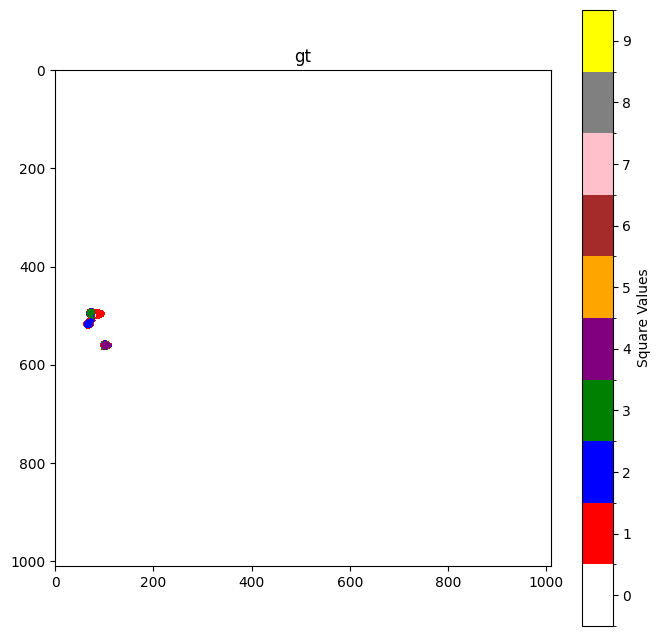

In [53]:
show_image(test_im, 'gt')

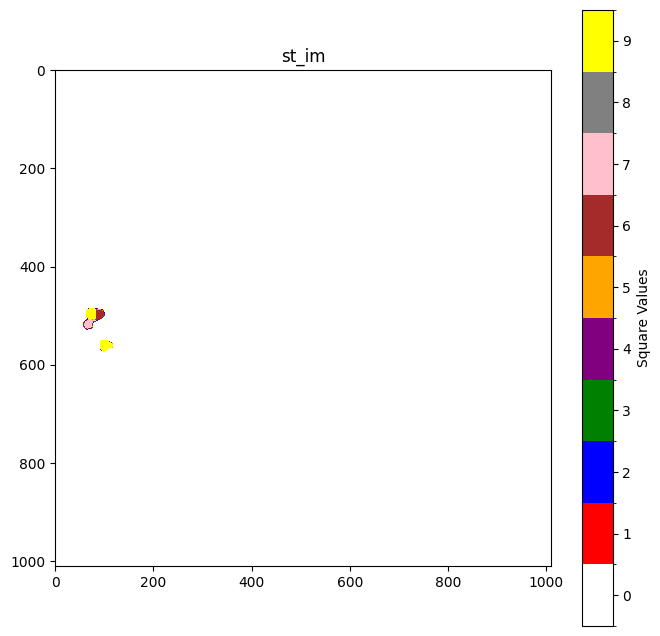

In [47]:
show_image(st_im, 'st_im')

In [52]:
np.unique(st_im)

array([  0,   6,   7, 634, 635], dtype=uint16)

In [50]:
st_im = tifffile.imread('inputs-2020-07/BF-C2DL-HSC/02_GT/TRA/man_track0287.tif')

In [ ]:
overall_scores

In [6]:
def show_image(img, name):
    # Define fixed colors for each value (0 to 9)
    colors = [
        'white',      # 0: background
        'red',        # 1: first square
        'blue',       # 2: second square
        'green',      # 3: third square
        'purple',     # 4: fourth square
        'orange',     # 5: fifth square
        'brown',      # 6: sixth square
        'pink',       # 7: seventh square
        'gray',       # 8: eighth square
        'yellow'      # 9: ninth square
    ]
    
    # Create a colormap with fixed boundaries
    cmap = mcolors.ListedColormap(colors)
    
    # Create proper normalization
    bounds = np.arange(-0.5, len(colors) + 0.5, 1)
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(img, cmap=cmap, norm=norm)
    plt.colorbar(label='Square Values', ticks=range(len(colors)))
    plt.title(f'{name}')
    plt.show()